In [1]:
# note: the naming of the metallicity is confusing.
# mh_gspphot is the iron abundance
# fem_gspspec + mh_gspspec = feh_gspspec (see documentation)
# also note that gspphot does not report alpha/fe
# I should make a note of this in the code and also in the paper
# in the form of axis labels?

In [2]:
# note: set family='monospace'
import pandas as pd
from matplotlib.markers import MarkerStyle
%pylab inline

# load spocs data
spocs_cannon_labels = pd.read_csv('../data/label_dataframes/spocs_cannon_labels.csv')
spocs_gaia_labels = pd.read_csv('../data/label_dataframes/spocs_labels.csv')

cannon_columns = ['source_id','cannon_teff', 'cannon_logg', 'cannon_feh',\
                  'cannon_alpha', 'cannon_vbroad']
spocs_labels = pd.merge(spocs_gaia_labels, 
              spocs_cannon_labels[cannon_columns], 
              on='source_id')
spocs_labels = spocs_labels.rename(columns={
    "Teff":"teff",
    "Vbr":"vbr"
})


# load CKS data
cks_cannon_labels = pd.read_csv('../data/label_dataframes/cks_cannon_labels.csv')
cks_gaia_labels = pd.read_csv('../data/label_dataframes/cks_labels.csv')
cks_labels = pd.merge(cks_gaia_labels, 
              cks_cannon_labels[cannon_columns], 
              on='source_id')
cks_labels = cks_labels.rename(columns={
    "cks_steff":"teff",
    "cks_slogg":"logg",
    "cks_smet":"feh",
    "cks_svsini":"vbr"
})

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
def bias_rms_label(x, y):
    diff = y - x
    # need to account for nan values in diff
    bias = np.round(np.nanmean(diff), 3)
    rms = np.round(np.sqrt(np.nansum(diff**2)/np.sum(np.isfinite(diff))), 3)
    label = 'bias, rms = {}, {}'.format(bias, rms)
    return label

def plot_one_to_one(x, y, range, nanc='b'):
    rmin, rmax = range
    c1 = 'b'
    plot([rmin, rmax], [rmin, rmax], lw=0.7, color='DarkGray')
    plot(x, y, 'o', color=c1)
    plt.plot([], [], '.', color=c1, label=bias_rms_label(x, y), alpha=0)
    
    # horiztonal line for nans y
    for idx in np.where(np.isnan(y))[0]:
        axvline(x.iloc[idx], color=nanc, lw=0.5,zorder=0)
    # vertical line for nans in x
    for idx in np.where(np.isnan(x))[0]:
        axhline(y.iloc[idx], color=nanc, lw=0.5,zorder=0)
        
    plt.legend(
        loc='upper left', 
        frameon=False, 
        labelcolor='linecolor')
    xlim(rmin, rmax);ylim(rmin, rmax)
    
def plot_one_to_one_cannon(x, y_gspphot, y_gspspec, y_cannon, range):
    
    c1='b'
    rmin, rmax = range
    plot([rmin, rmax], [rmin, rmax], lw=0.7, color='DarkGray')
    plot([], [], '.', color=c1, label=bias_rms_label(x, y_cannon), alpha=0)
    
    nan_gspphot = np.where(np.isnan(y_gspphot))[0]
    nan_gspspec = np.where(np.isnan(y_gspspec))[0]
    nan_both = np.where(np.isnan(y_gspphot) & np.isnan(y_gspspec))[0]

    plot(x, y_cannon, 'bo')
    plot(x[nan_gspphot], y_cannon[nan_gspphot], 'ro')
    plot(x[nan_gspspec], y_cannon[nan_gspspec], 'o', color='orange')
    scatter(x[nan_both], y_cannon[nan_both], edgecolor=None, color='r',
            marker=MarkerStyle("o", fillstyle="right"), zorder=10)
    
    plt.legend(
        loc='upper left', 
        frameon=False, 
        labelcolor='linecolor')
    xlim(rmin, rmax);ylim(rmin, rmax)

def plot_cannon_gaia_agreement(labels, suptitle_str,color_nans=False):
    figure(figsize=(15,25))
    rcParams['figure.dpi']=150
    suptitle(suptitle_str, y=0.91, fontsize=15)
    
    if color_nans:
        nancphot = 'r'
        nancspec = 'orange'
    else:
        nancphot = 'b'
        nancspec = 'b'

    tight_layout()
    # teff plots
    subplot(531);ylabel(r'T$_{\rm eff}$ (K)');title('Gaia GspPhot')
    plot_one_to_one(labels.teff, labels.teff_gspphot, range=(4500,7000),nanc=nancphot)
    subplot(532);title('Gaia GspSpec')
    plot_one_to_one(labels.teff, labels.teff_gspspec, range=(4500,7000),nanc=nancspec)
    subplot(533);title('Cannon Model')
    if color_nans:
        plot_one_to_one_cannon(
            labels.teff, 
            labels.teff_gspphot,
            labels.teff_gspspec,
            labels.cannon_teff,
            (4500,7000))
    else:
        plot_one_to_one(labels.teff, labels.cannon_teff, range=(4500,7000))

    # logg plots
    subplot(534);ylabel(r'log$g$ (dex)')
    plot_one_to_one(labels.logg, labels.logg_gspphot, range=(3,5.5),nanc=nancphot)
    subplot(535)
    plot_one_to_one(labels.logg, labels.logg_gspspec, range=(3,5.5),nanc=nancspec)
    subplot(536)
    if color_nans:
        plot_one_to_one_cannon(
            labels.logg, 
            labels.logg_gspphot,
            labels.logg_gspspec,
            labels.cannon_logg,
            (3,5.5))
    else:
        plot_one_to_one(labels.logg, labels.cannon_logg, range=(3,5.5))

    # feh plots
    subplot(537);ylabel('[Fe/H] (dex)')
    plot_one_to_one(labels.feh, labels.mh_gspphot, range=(-1,1),nanc=nancphot)
    subplot(538)
    plot_one_to_one(labels.feh, labels.fem_gspspec + labels.mh_gspspec, range=(-1,1),nanc=nancspec)
    subplot(539)
    if color_nans:
        plot_one_to_one_cannon(
            labels.feh, 
            labels.mh_gspphot,
            labels.fem_gspspec + labels.mh_gspspec,
            labels.cannon_feh,
            (-1,1))
    else:
        plot_one_to_one(labels.feh, labels.cannon_feh, range=(-1,1))

    # SPOCS doesn't report alpha so I'm skipping this one

    # vbroad plots
    subplot(5,3,10);ylabel(r'v$_{\rm broad}$ (km/s)')
    plot_one_to_one(labels.vbr, labels.vbroad, range=(0,30),nanc=nancphot)

    subplot(5,3,12)
    if color_nans:
        plot_one_to_one_cannon(
            labels.vbr, 
            labels.vbroad,
            # this can be anything, it doesnt get plotted
            np.nan*np.ones(len(labels.vbroad)), 
            labels.cannon_vbroad,
            (0,30))
    else:
        plot_one_to_one(labels.vbr, labels.cannon_vbroad, range=(0,30))

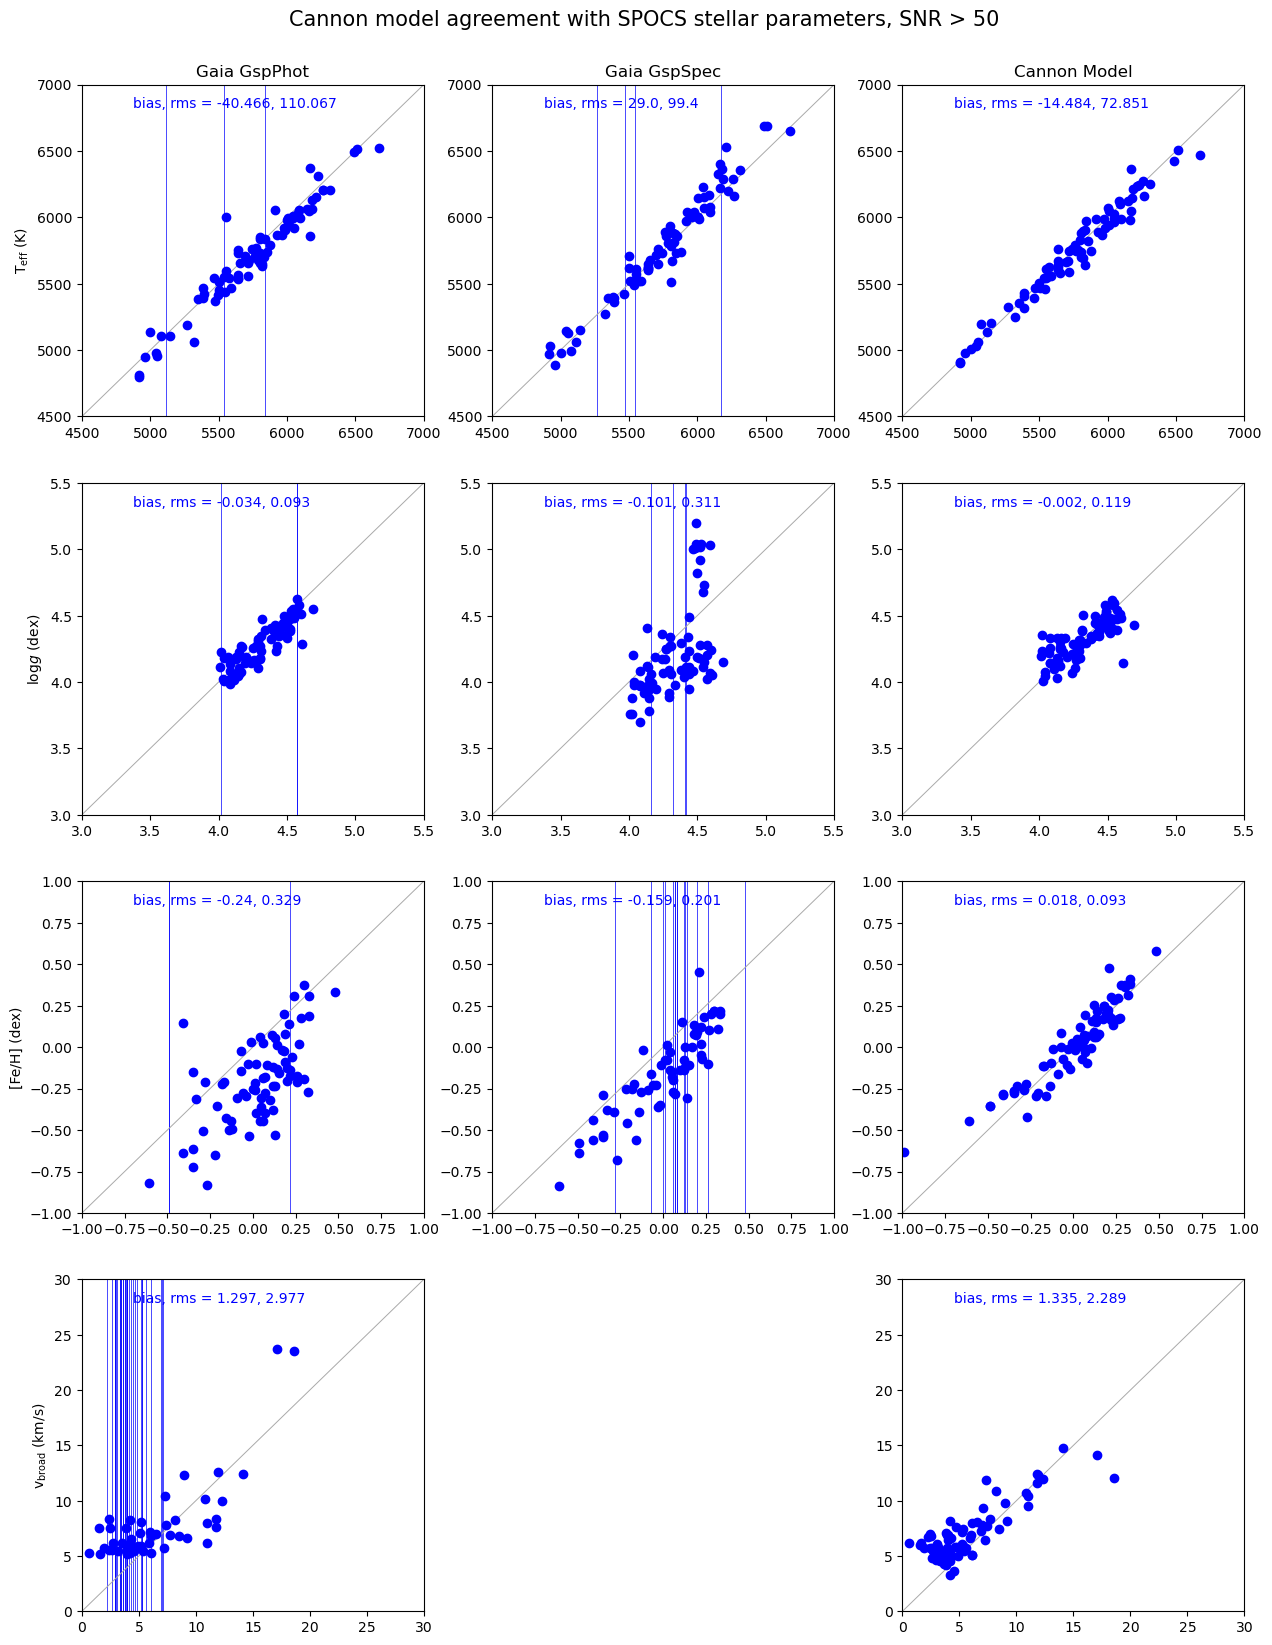

In [4]:
plot_cannon_gaia_agreement(
    spocs_labels.query('rvs_spec_sig_to_noise > 50'), 
    'Cannon model agreement with SPOCS stellar parameters, SNR > 50')
savefig('./figures/cannon_versus_spocs_snr50.png', dpi=300, bbox_inches='tight')

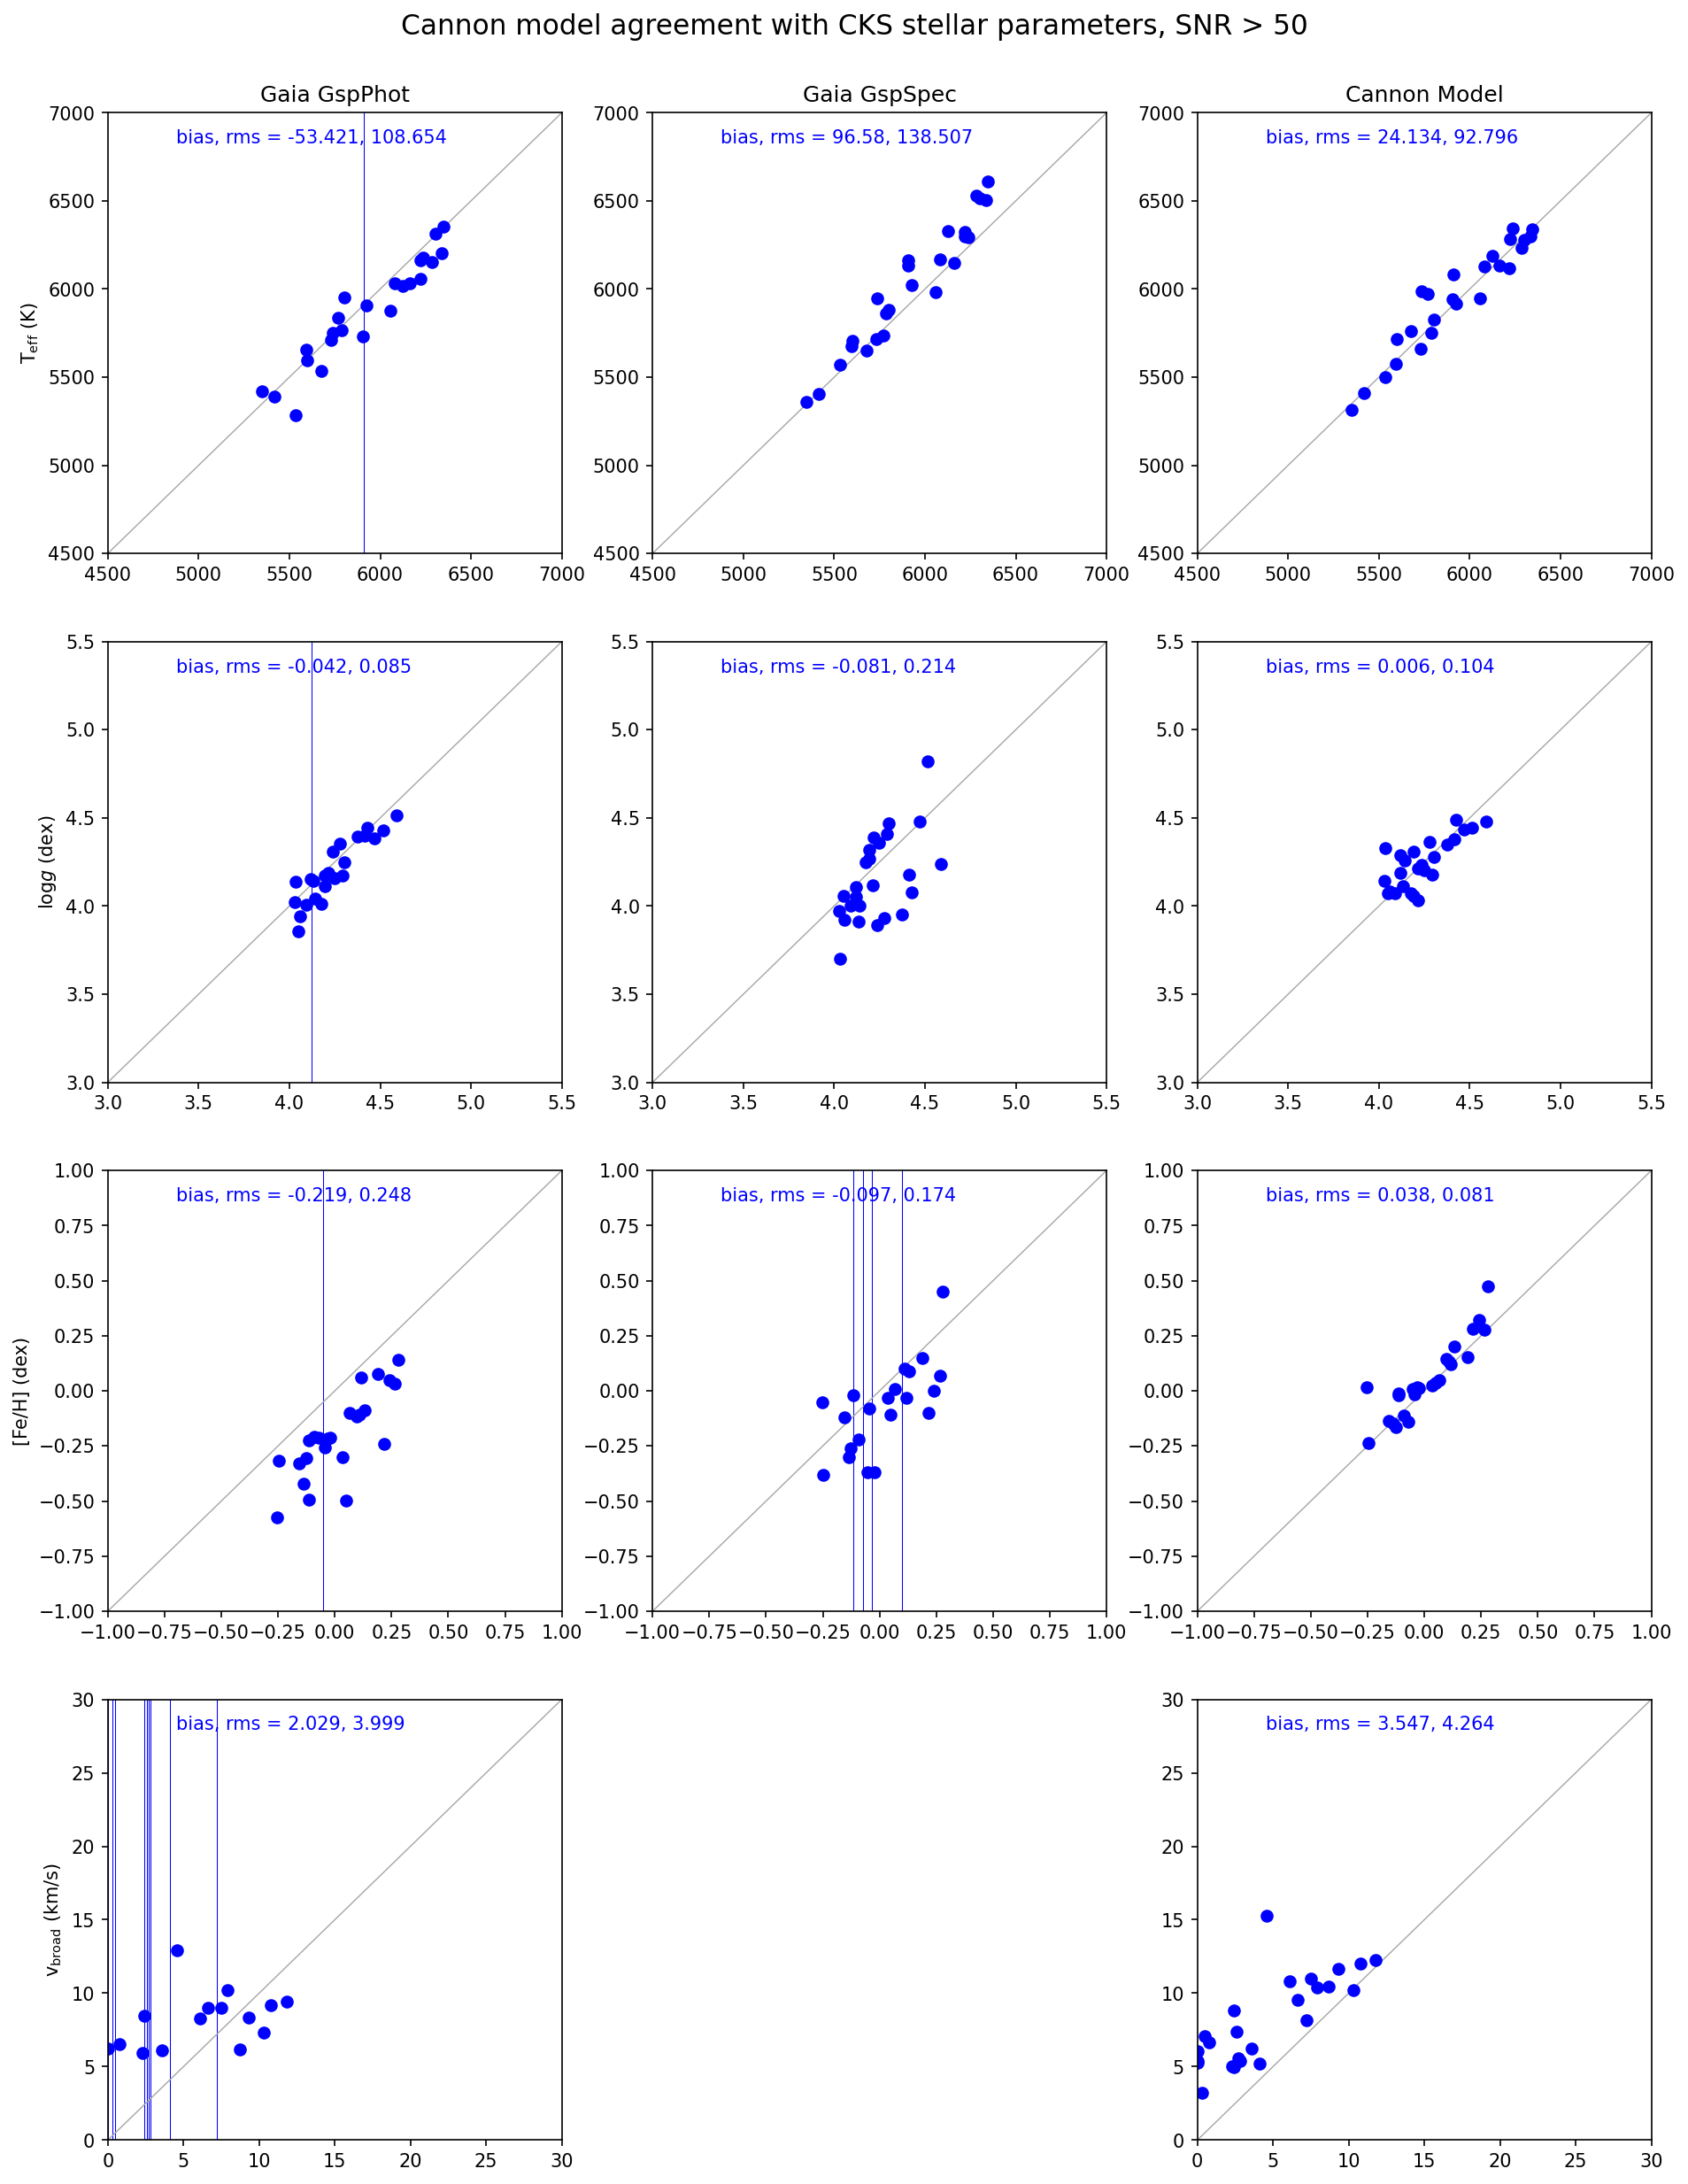

In [5]:
plot_cannon_gaia_agreement(
    cks_labels.query('rvs_spec_sig_to_noise > 50'), 
    'Cannon model agreement with CKS stellar parameters, SNR > 50')
savefig('./figures/cannon_versus_cks_snr50.png', dpi=300, bbox_inches='tight')

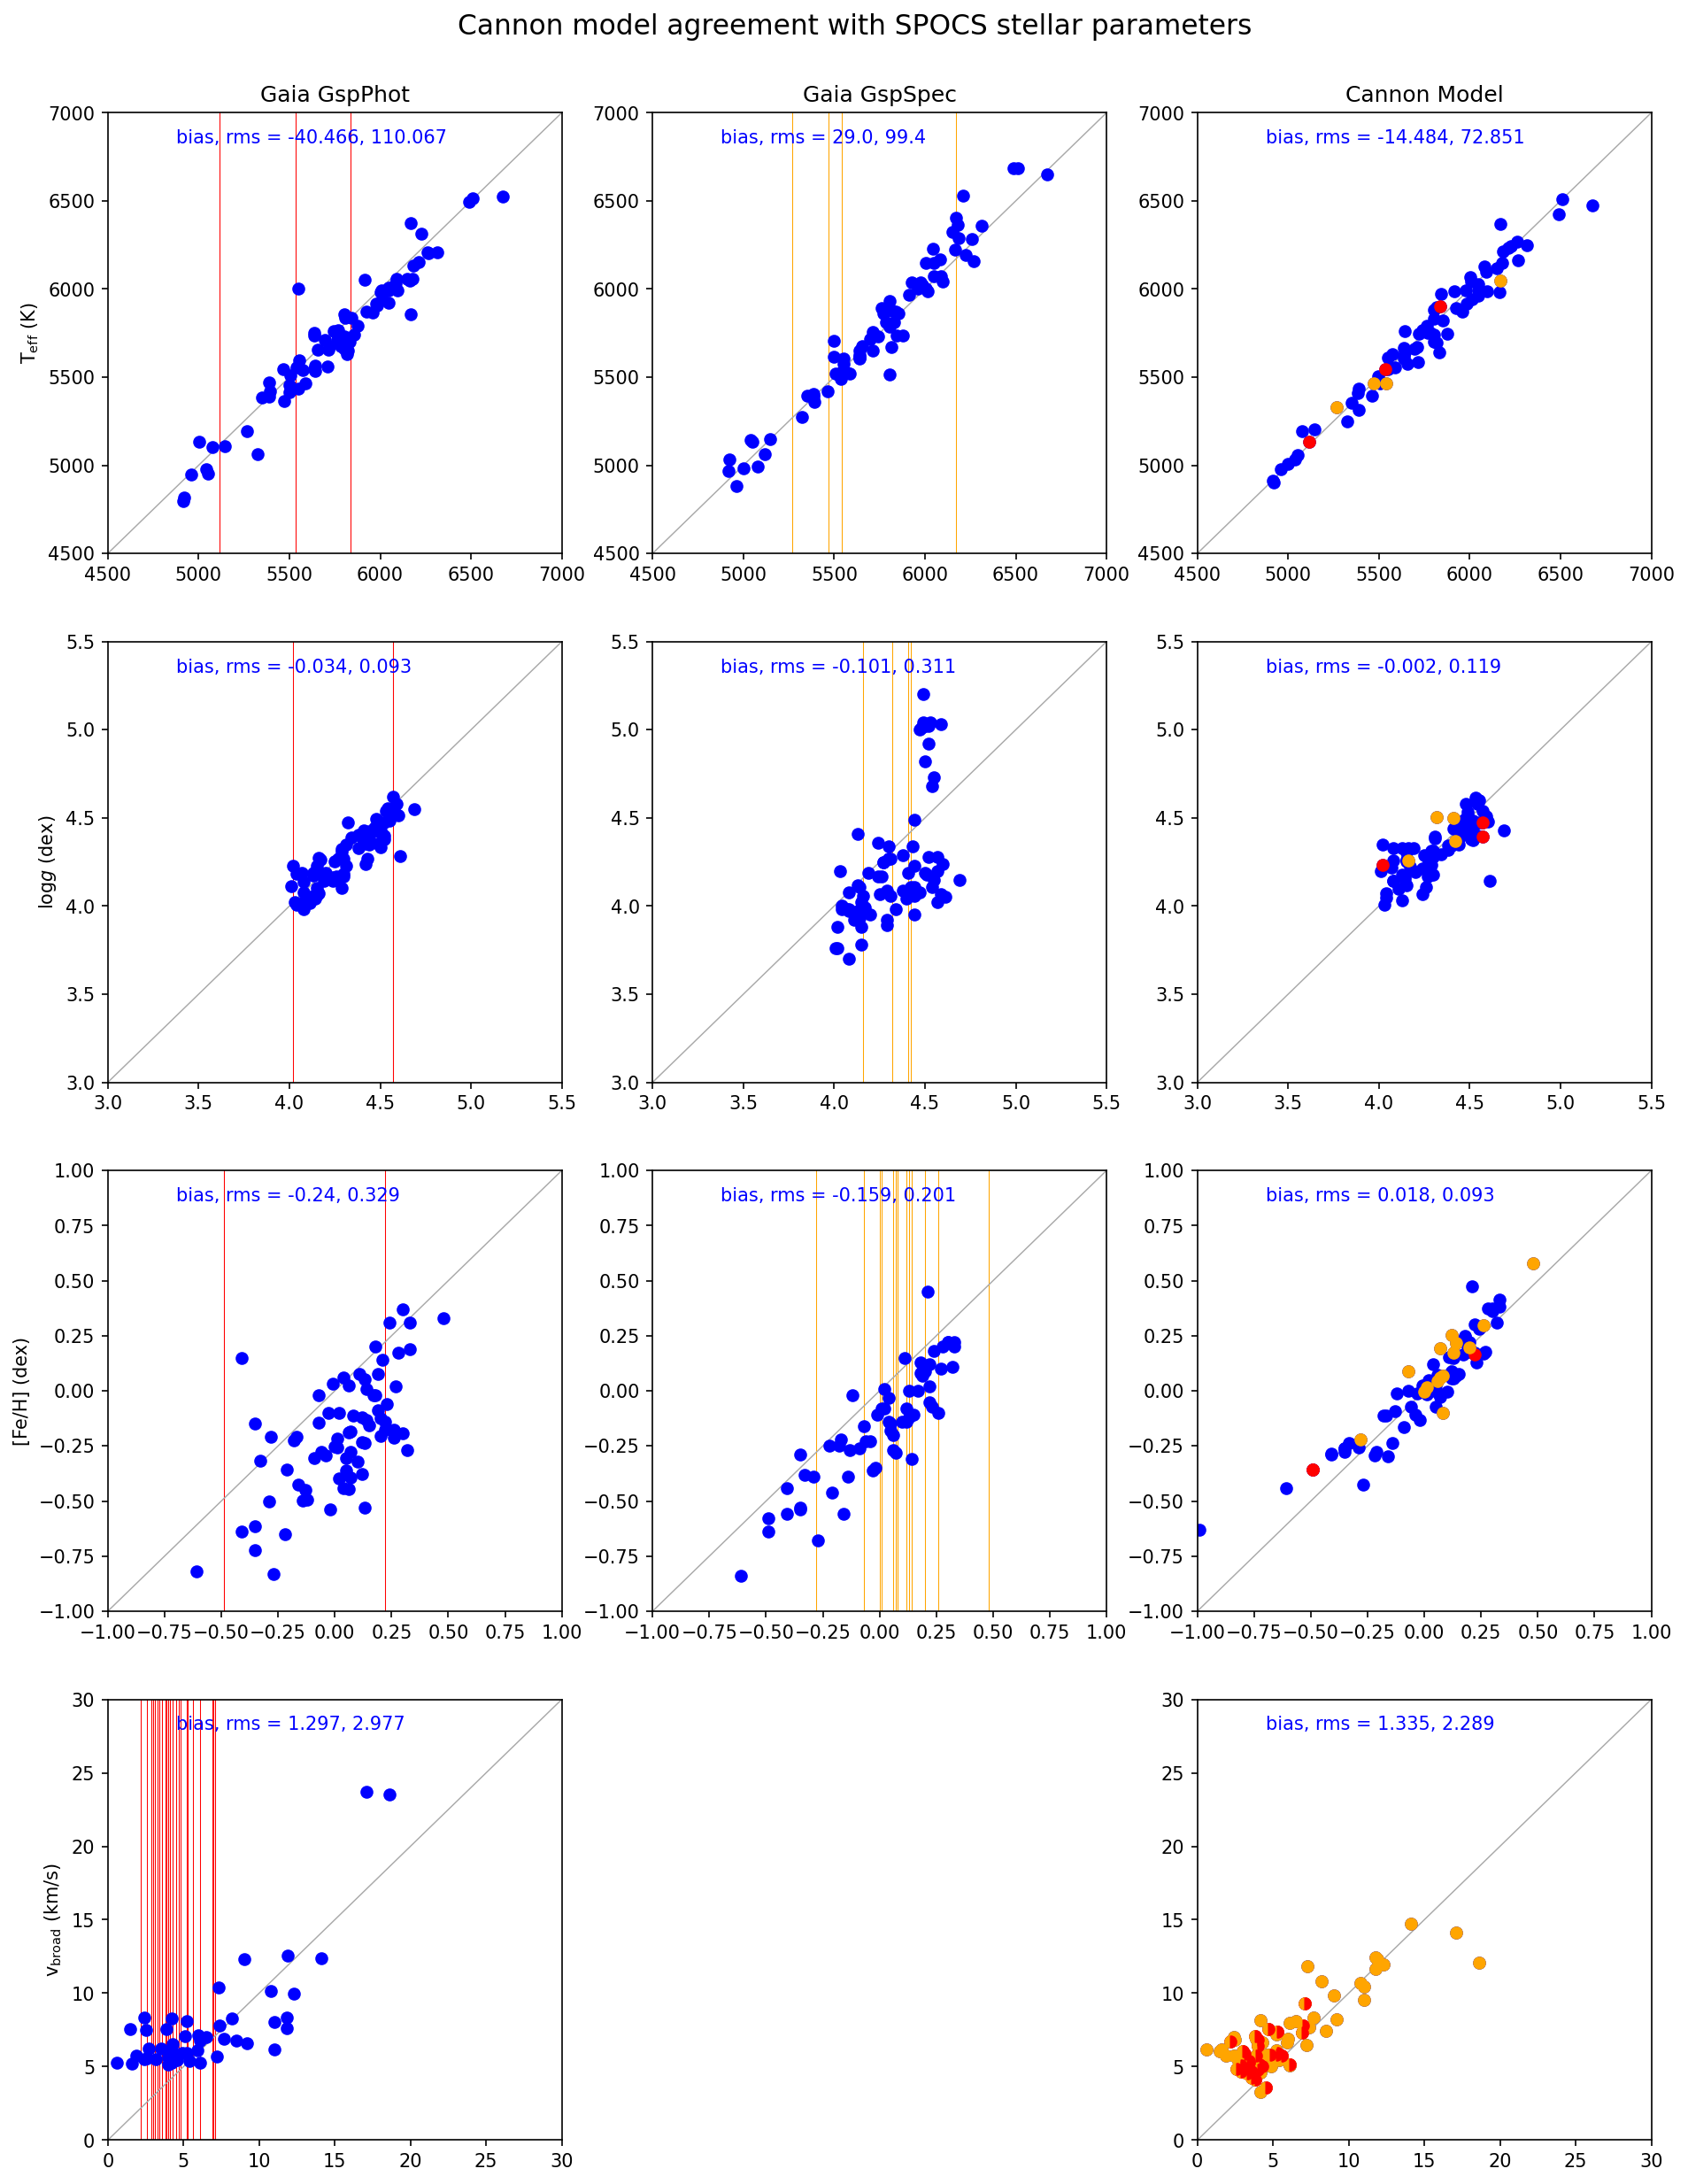

In [6]:
plot_cannon_gaia_agreement(spocs_labels, 'Cannon model agreement with SPOCS stellar parameters',
                          color_nans=True)
savefig('./figures/cannon_versus_spocs.png', dpi=300, bbox_inches='tight')

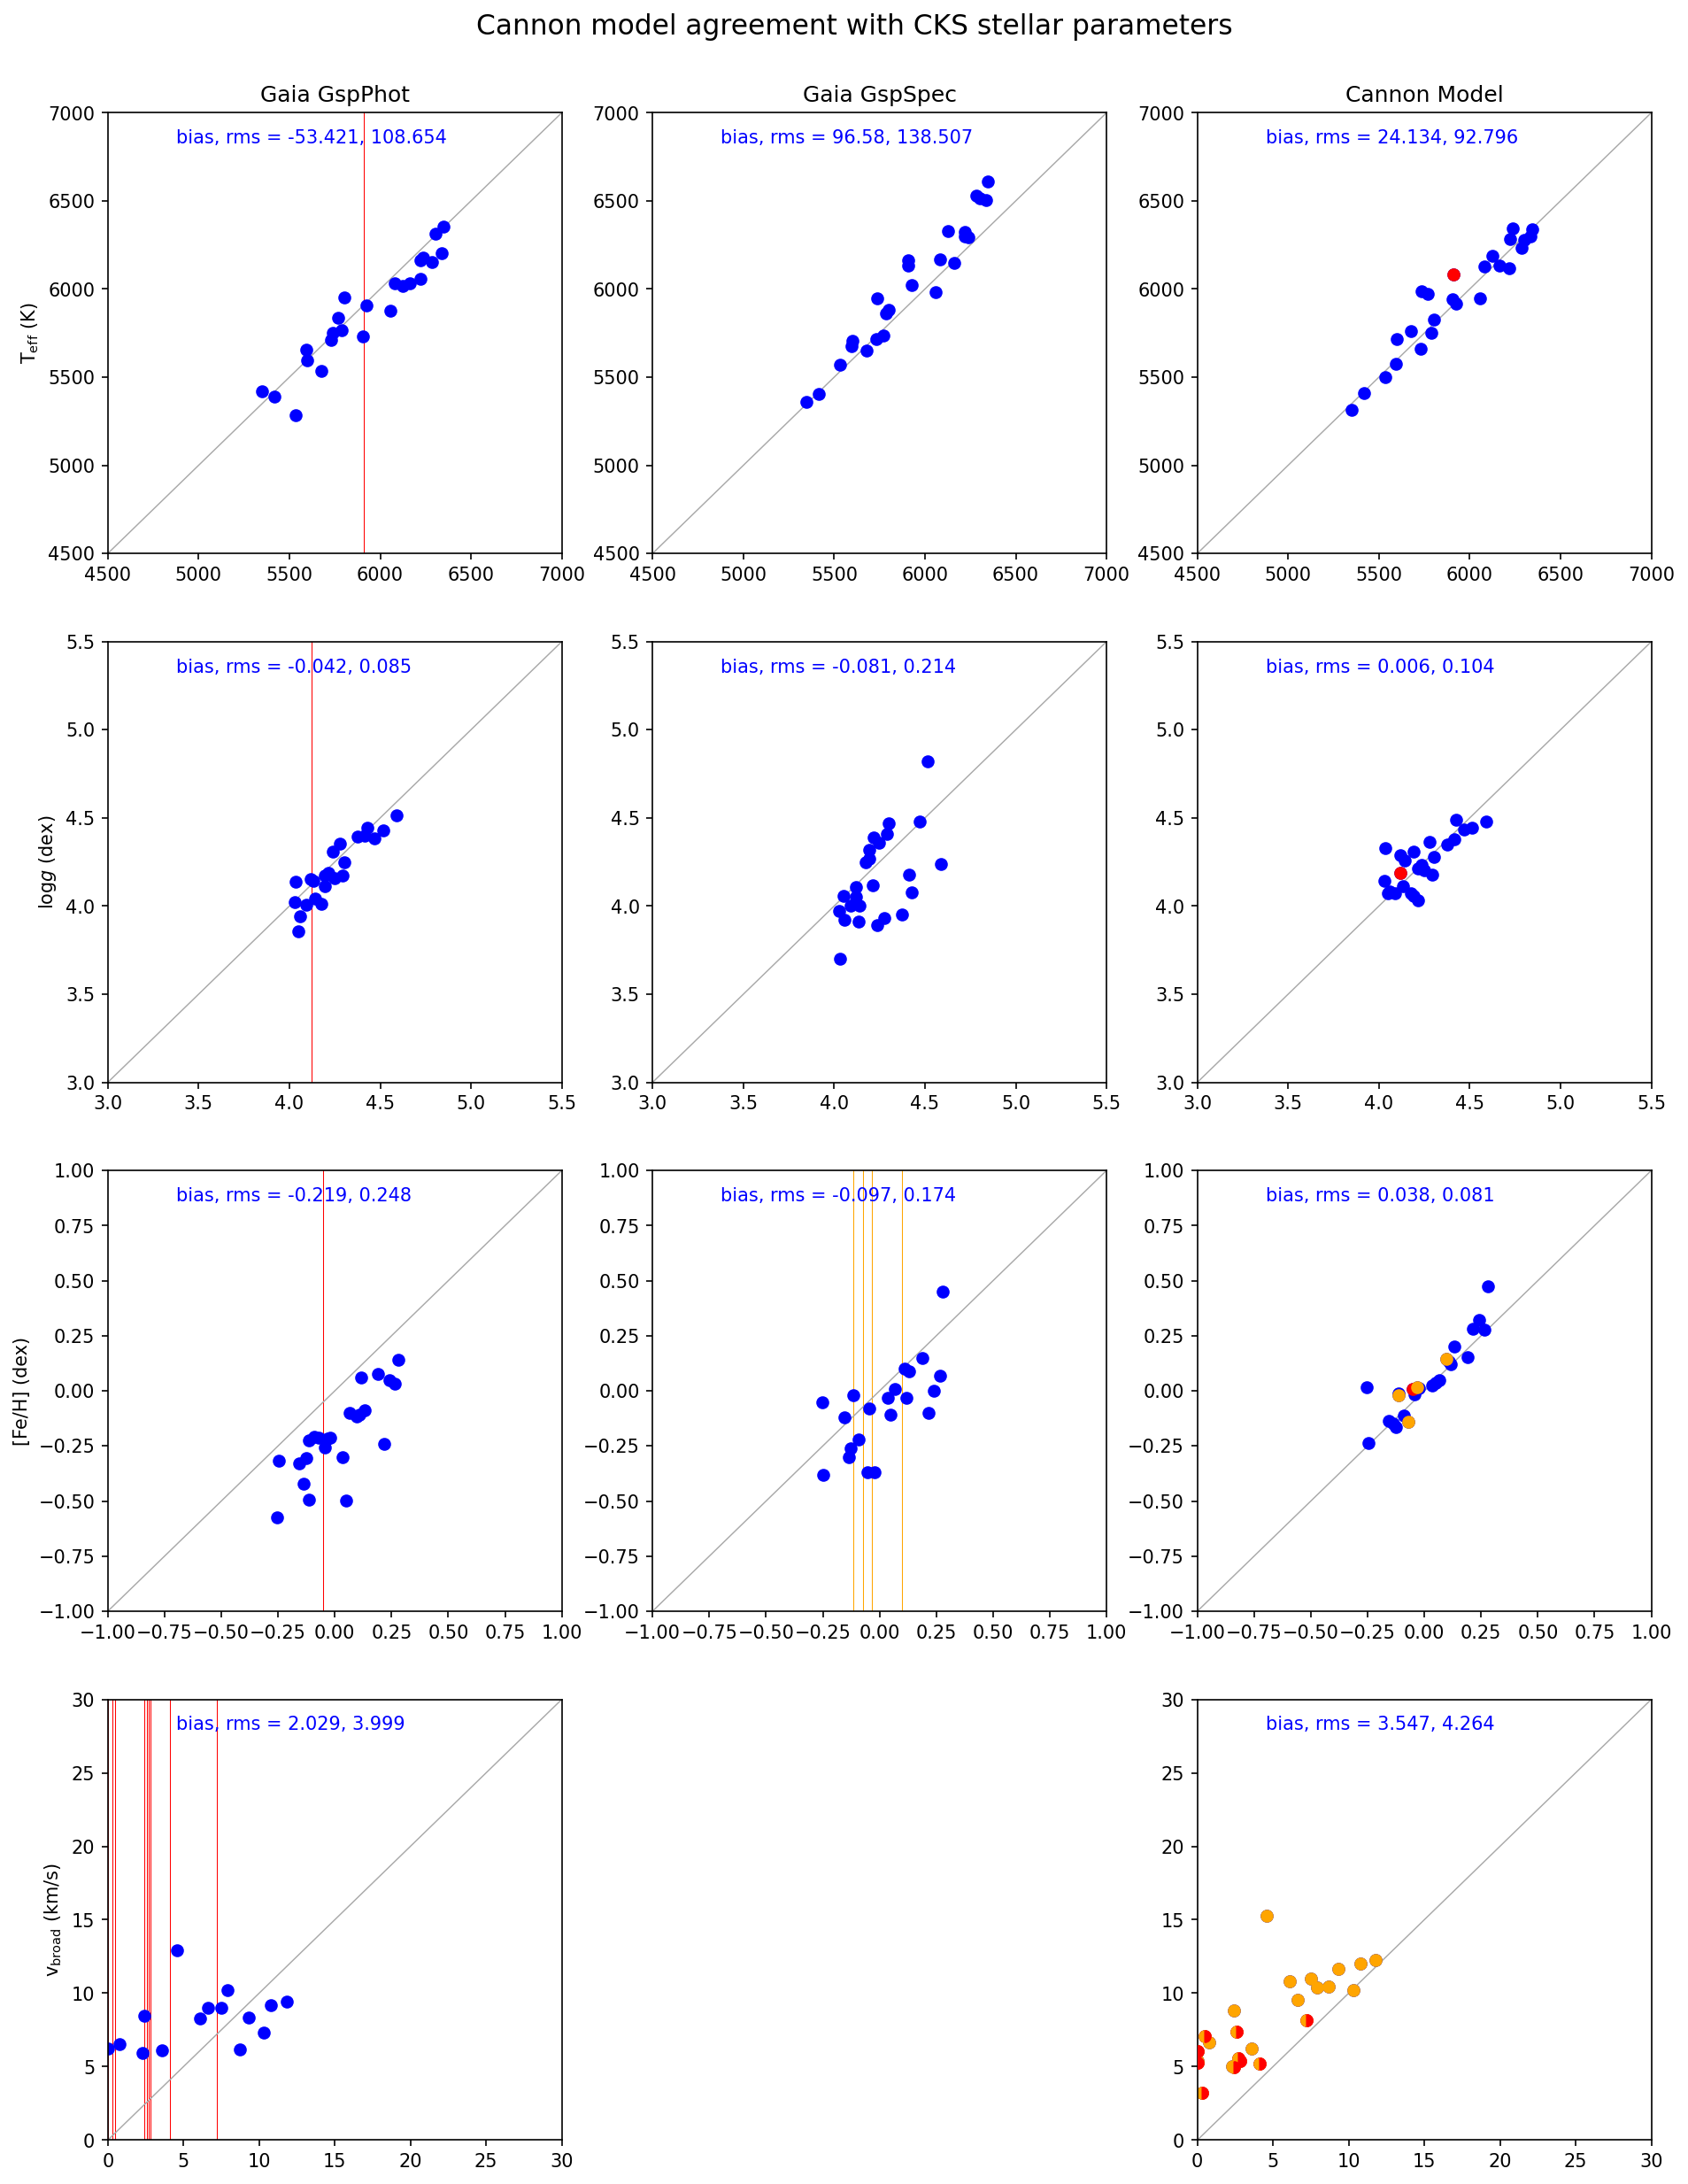

In [7]:
plot_cannon_gaia_agreement(cks_labels, 'Cannon model agreement with CKS stellar parameters',
                          color_nans=True)
savefig('./figures/cannon_versus_cks.png', dpi=300, bbox_inches='tight')

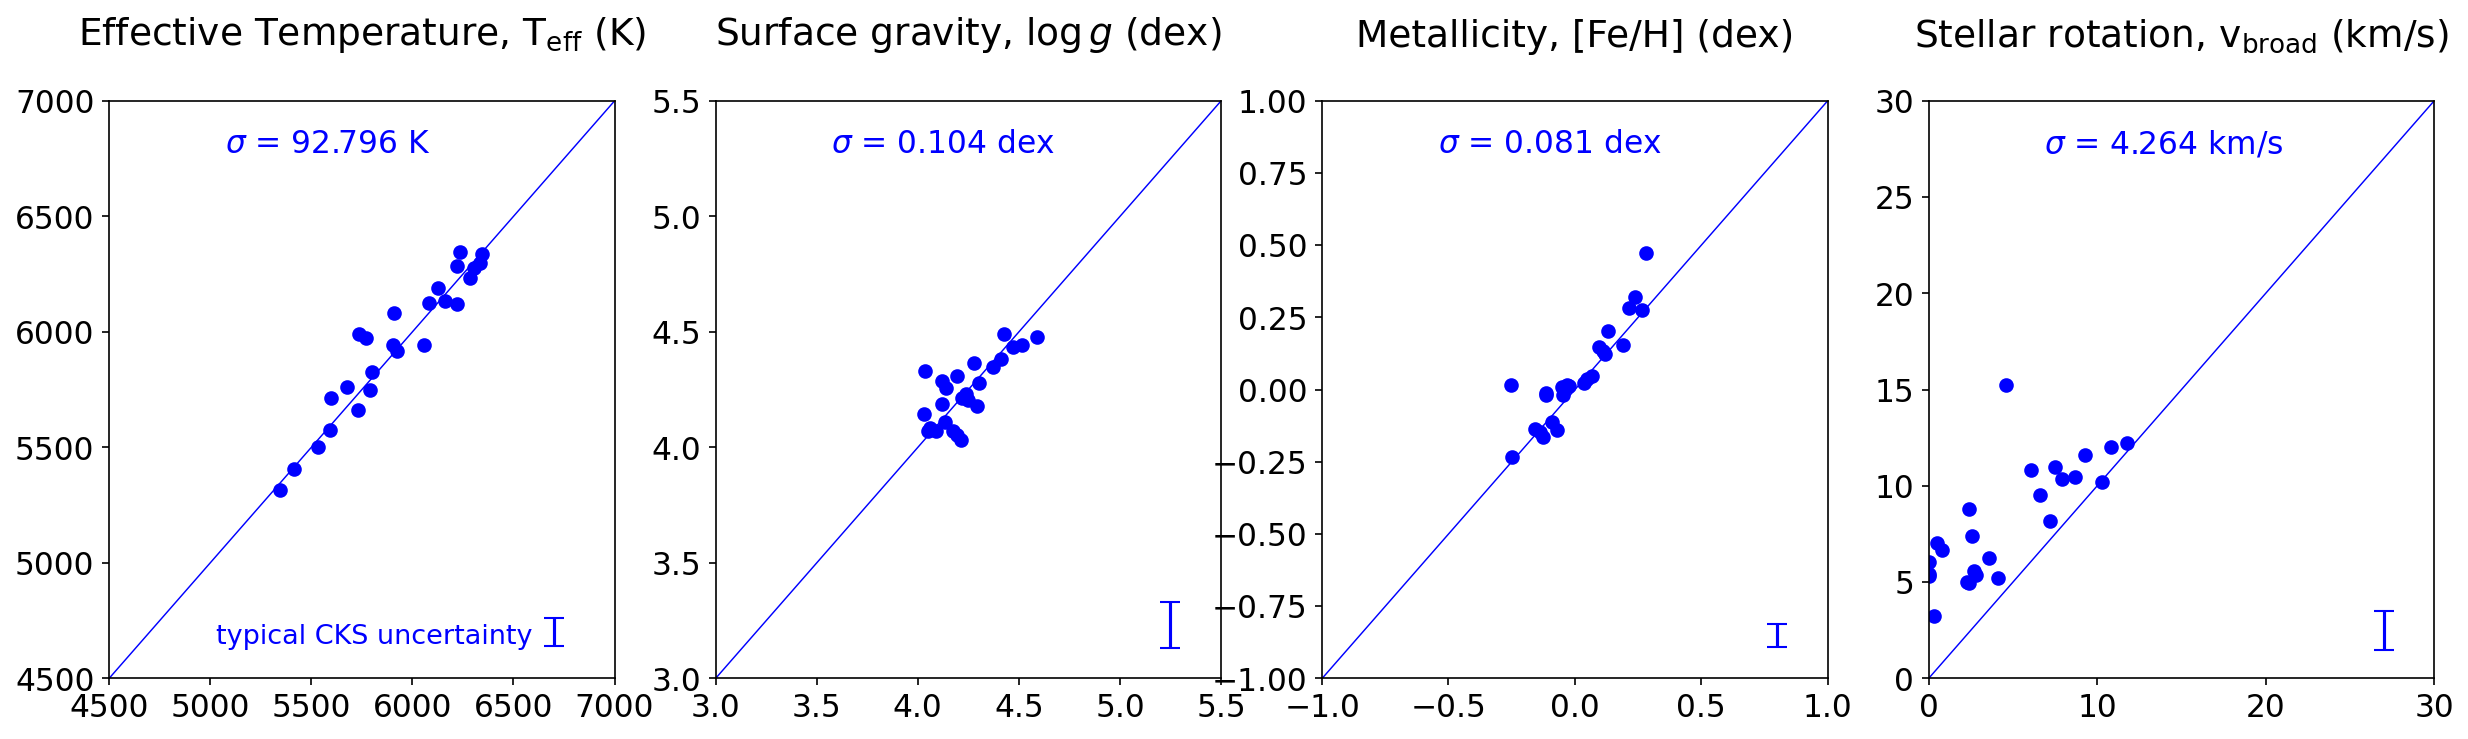

In [89]:
# okay really I just need the 5 labels
# with the agreement
rcParams['font.size']=15
def bias_rms_label(x, y, unit_str):
    diff = y - x
    # need to account for nan values in diff
    bias = np.round(np.nanmean(diff), 3)
    rms = np.round(np.sqrt(np.nansum(diff**2)/np.sum(np.isfinite(diff))), 3)
    label = r'$\sigma$ = {} {}'.format(rms, unit_str)
    return label

def plot_one_to_one(x, y, range, unit_str='', nanc='b'):
    rmin, rmax = range
    c1 = 'b'
    plot([rmin, rmax], [rmin, rmax], lw=0.7, color='b')
    plot(x, y, 'o', color=c1)
    plt.plot([], [], '.', color=c1, label=bias_rms_label(x, y, unit_str), alpha=0)
    
    # horiztonal line for nans y
    for idx in np.where(np.isnan(y))[0]:
        axvline(x.iloc[idx], color=nanc, lw=0.5,zorder=0)
    # vertical line for nans in x
    for idx in np.where(np.isnan(x))[0]:
        axhline(y.iloc[idx], color=nanc, lw=0.5,zorder=0)
        
    plt.legend(
        loc='upper left', 
        frameon=False, 
        labelcolor='linecolor',
    fontsize=15)
    xlim(rmin, rmax);ylim(rmin, rmax)

def custom_plot(labels, suptitle_str):
    figure(figsize=(20,5))
    rcParams['figure.dpi']=150
    suptitle(suptitle_str, y=0.91, fontsize=15)
    
    # errorbars
    teff_err = labels.cks_steff_err1.mean()
    logg_err = labels.cks_slogg_err1.mean()
    feh_err = labels.cks_smet_err1.mean()
    vbroad_err = labels.cks_svsini_err1.mean()
    efmt = ''
    ecapsize=5
    ec='b'

    subplot(141);title(r'Effective Temperature, T$_{\rm eff}$ (K)'+'\n')
    plot_one_to_one(labels.teff, labels.cannon_teff, range=(4500,7000), unit_str='K')
    errorbar(6700,4700,yerr=teff_err, fmt=efmt, color=ec,capsize=ecapsize)
    text(5030,4650,'typical CKS uncertainty',color=ec,fontsize=13)

    subplot(142);title(r'Surface gravity, log$\,g$ (dex)'+'\n')
    plot_one_to_one(labels.logg, labels.cannon_logg, range=(3,5.5), unit_str='dex')
    errorbar(5.25,3.23,yerr=logg_err, fmt=efmt, color=ec,capsize=ecapsize)

    subplot(143);title('Metallicity, [Fe/H] (dex)'+'\n')
    plot_one_to_one(labels.feh, labels.cannon_feh, range=(-1,1), unit_str='dex')
    errorbar(0.8,-0.85,yerr=feh_err, fmt=efmt, color=ec,capsize=ecapsize)
    
    subplot(1,4,4);title(r'Stellar rotation, v$_{\rm broad}$ (km/s)'+'\n')
    plot_one_to_one(labels.vbr, labels.cannon_vbroad, range=(0,30), unit_str='km/s')
    errorbar(27,2.5,yerr=vbroad_err, fmt=efmt, color=ec,capsize=ecapsize)

custom_df = cks_labels.query('rvs_spec_sig_to_noise > 50'+'\n')
custom_plot(
    custom_df, 
    '')

Index(['Unnamed: 0', 'source_id', 'id_kic', 'kepid', 'teff', 'cks_steff_err1',
       'cks_steff_err2', 'logg', 'cks_slogg_err1', 'cks_slogg_err2', 'feh',
       'cks_smet_err1', 'cks_smet_err2', 'vbr', 'cks_svsini_err1',
       'cks_svsini_err2', 'rvs_spec_sig_to_noise', 'ra', 'dec',
       'non_single_star', 'ruwe', 'radial_velocity', 'radial_velocity_error',
       'rv_nb_transits', 'teff_gspphot', 'teff_gspphot_lower',
       'teff_gspphot_upper', 'logg_gspphot', 'logg_gspphot_lower',
       'logg_gspphot_upper', 'mh_gspphot', 'mh_gspphot_lower',
       'mh_gspphot_upper', 'teff_gspspec', 'teff_gspspec_lower',
       'teff_gspspec_upper', 'logg_gspspec', 'logg_gspspec_lower',
       'logg_gspspec_upper', 'fem_gspspec', 'fem_gspspec_lower',
       'fem_gspspec_upper', 'mh_gspspec', 'mh_gspspec_lower',
       'mh_gspspec_upper', 'alphafe_gspspec', 'alphafe_gspspec_lower',
       'alphafe_gspspec_upper', 'vbroad', 'vbroad_error', 'cannon_teff',
       'cannon_logg', 'cannon_feh', 'can